Library instalation

In [9]:
!pip install -U datasets huggingface_hub fsspec
!pip install -U scikit-learn

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


Data loading/parsing

In [10]:
import datasets

In [11]:
#load datasets
dataset1_raw = datasets.load_dataset("ThatOneShortGuy/SongLyrics", split="train",num_proc=3)
dataset2_raw = datasets.load_dataset("sebastiandizon/genius-song-lyrics", split="train",num_proc=3)
dataset3_raw = datasets.load_dataset("amishshah/song_lyrics", split="train",num_proc=3)

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Remove all non english songs

In [12]:
def language_filter(entry: dict, *extra_args):
    return entry['language'] == 'en'


dataset2_raw = dataset2_raw.filter(language_filter, num_proc=3)

In [13]:
# make so that all datasets have equal fields
print("before cleanup:")
print(dataset1_raw)
print(dataset2_raw)
print(dataset3_raw)

dataset1 = dataset1_raw
dataset2 = dataset2_raw
dataset3 = dataset3_raw

dataset1 = dataset1.remove_columns(
    ["id", "artist", 'image_url', 'release_day', 'release_month', 'release_year', 'pageviews'])
dataset2 = dataset2.remove_columns(['artist', 'year', 'views', 'features', 'id', 'language_cld3', 'language_ft'])
dataset3 = dataset3.remove_columns(['Unnamed: 0'])

dataset1 = dataset1.remove_columns(['title'])
dataset2 = dataset2.remove_columns(['title', 'language'])
dataset3 = dataset3.remove_columns(['title'])

dataset1 = dataset1.rename_column('genre', 'tag')

# language_column = ["en"] * len(dataset1)
# dataset1 = dataset1.add_column("language", language_column)

# language_column = ["en"] * len(dataset3)
# dataset3 = dataset3.add_column("language", language_column)

print("after cleanup:")
print(dataset1)
print(dataset2)
print(dataset3)

before cleanup:
Dataset({
    features: ['id', 'title', 'artist', 'lyrics', 'genre', 'image_url', 'release_day', 'release_month', 'release_year', 'pageviews'],
    num_rows: 451736
})
Dataset({
    features: ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language'],
    num_rows: 3374198
})
Dataset({
    features: ['Unnamed: 0', 'title', 'tag', 'lyrics'],
    num_rows: 3374198
})
after cleanup:
Dataset({
    features: ['lyrics', 'tag'],
    num_rows: 451736
})
Dataset({
    features: ['tag', 'lyrics'],
    num_rows: 3374198
})
Dataset({
    features: ['tag', 'lyrics'],
    num_rows: 3374198
})


Data splitting

In [14]:
#split datasets
dataset1_split = dataset1.train_test_split(test_size=0.1)
dataset2_split = dataset2.train_test_split(test_size=0.1)
dataset3_split = dataset3.train_test_split(test_size=0.1)

print(dataset1_split)
print(dataset2_split)
print(dataset3_split)

DatasetDict({
    train: Dataset({
        features: ['lyrics', 'tag'],
        num_rows: 406562
    })
    test: Dataset({
        features: ['lyrics', 'tag'],
        num_rows: 45174
    })
})
DatasetDict({
    train: Dataset({
        features: ['tag', 'lyrics'],
        num_rows: 3036778
    })
    test: Dataset({
        features: ['tag', 'lyrics'],
        num_rows: 337420
    })
})
DatasetDict({
    train: Dataset({
        features: ['tag', 'lyrics'],
        num_rows: 3036778
    })
    test: Dataset({
        features: ['tag', 'lyrics'],
        num_rows: 337420
    })
})


In [15]:
#combine datasets in to 2 large ones, train and test
dataset_train = datasets.concatenate_datasets(
    [dataset1_split["train"], dataset2_split["train"], dataset3_split["train"]])
dataset_test = datasets.concatenate_datasets([dataset1_split["test"], dataset2_split["test"], dataset3_split["test"]])
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['lyrics', 'tag'],
    num_rows: 6480118
})
Dataset({
    features: ['lyrics', 'tag'],
    num_rows: 720014
})


See how the dataset looks by tags before further normalization and combination

In [16]:
from collections import Counter

In [17]:
print("Before normalization and tag combination:")
# Group, count
train_counted = Counter(dataset_train['tag'])
test_counted = Counter(dataset_test['tag'])

# Special variable for not showing records when their count is lower than...
MIN_COUNT = 1000

# Print (and also populate tag list)
print("In train:")
for tag, count in train_counted.items():
    if (count < MIN_COUNT):
        continue
    print(f"Tag {tag}: {count} records")

print("In test:")
for tag, count in test_counted.items():
    if (count < MIN_COUNT):
        continue
    print(f"Tag {tag}: {count} records")

Before normalization and tag combination:
In train:
Tag Rock: 75758 records
Tag Unknown: 38229 records
Tag BluesFolk: 5357 records
Tag Hip-HopRap: 28682 records
Tag Alternative: 26918 records
Tag Reggae: 2850 records
Tag Country: 38861 records
Tag Jazz: 5448 records
Tag Electronic: 3300 records
Tag Hip-Hop: 12100 records
Tag Pop: 34735 records
Tag Metal: 6299 records
Tag Rock  Roll: 1339 records
Tag RBSoul: 19321 records
Tag Soul: 4772 records
Tag Inspirational: 3006 records
Tag Alternative Country: 1808 records
Tag Indie Rock: 3998 records
Tag Hard Rock: 2104 records
Tag Classic Rock: 5221 records
Tag Rap: 5252 records
Tag DanceElectronic: 2138 records
Tag WorldReggae: 5554 records
Tag Contemporary Country: 2530 records
Tag WorldInternational: 5065 records
Tag PopRock: 5539 records
Tag ElectronicDance: 2343 records
Tag Dance: 1554 records
Tag SingerSongwriter: 3287 records
Tag RB: 2730 records
Tag Latin: 8373 records
Tag Easy ListeningVocal: 2220 records
Tag Punk: 1901 records
Tag Mem

Combine data together

In [18]:
# Manual mapping based on the results given:
# Combine similar, exclude unique (classical, regional mexicano...)
# Or vague (inspirational, world-international)

def mapping_func(row):
    # Declaring helper variables here since excluding them from here
    # Will fail num_proc attempts.
    # Constants to avoid possible misspellings
    ROCK_TAG = "rock"
    POP_TAG = "pop"
    RAP_TAG = "rap"
    COUNTRY_TAG = "country"
    RB_TAG = "rb"
    MISC_TAG = "misc"

    # Everything that is not a key in this map will be excluded.
    # Keys are normalized to lowercase to account for multiple similar records
    # (e.g. both "Rock" and "rock").
    tag_map = {
        # Rock
        "rock": ROCK_TAG,
        "metal": ROCK_TAG,
        "classic rock": ROCK_TAG,
        "hard rock": ROCK_TAG,
        "alternative": ROCK_TAG,
        "rock  roll": ROCK_TAG,
        "poprock": ROCK_TAG,
        "folk-rock": ROCK_TAG,
        "punk": ROCK_TAG,
        "indie rock": ROCK_TAG,
        # Pop
        "pop": POP_TAG,
        "disco": POP_TAG,
        "k-pop": POP_TAG,
        "j-pop": POP_TAG,
        # Rap
        "rap": RAP_TAG,
        "hip-hoprap": RAP_TAG,
        "anime rap": RAP_TAG,
        "hip-hop": RAP_TAG,
        "meme rap": RAP_TAG,
        # Country
        "country": COUNTRY_TAG,
        "outlaw country": COUNTRY_TAG,
        "contemporary country": COUNTRY_TAG,
        # R'n'B
        "rb": RB_TAG,
        "rbsoul": RB_TAG,
        "r&b": RB_TAG,
        "worldreggae": RB_TAG,
        # Misc
        # "misc": MISC_TAG,
        # "unknown": MISC_TAG,
        # "danceelectronic": MISC_TAG,
        # "electronic": MISC_TAG
    }
    # Normalize tag
    row_tag = row["tag"].strip().lower()
    if row_tag in tag_map:
        new_tag = tag_map[row_tag]
        return {"tag": new_tag}
    return {"tag": "rm"}


def mapping_func_filter(entry: dict, *extra_args):
    return entry["tag"] != 'rm'


# Normalize tags
dataset_train = dataset_train.map(mapping_func, num_proc=3)
dataset_train = dataset_train.filter(mapping_func_filter, num_proc=3)
# Normalize tags
dataset_test = dataset_test.map(mapping_func, num_proc=3)
dataset_test = dataset_test.filter(mapping_func_filter, num_proc=3)

Map (num_proc=3):   0%|          | 0/6480118 [00:00<?, ? examples/s]

Filter (num_proc=3):   0%|          | 0/6480118 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/720014 [00:00<?, ? examples/s]

Filter (num_proc=3):   0%|          | 0/720014 [00:00<?, ? examples/s]

In [19]:
# print(dataset_train)
# print(dataset_test)
# dataset_train.save_to_disk("dataset_train")
# dataset_test.save_to_disk("dataset_test")

In [20]:
# dataset_train=dataset_train.load_from_disk("dataset_train")
# dataset_test=dataset_test.load_from_disk("dataset_test")


In [14]:
print("After normalization and tag combination:")
# Group, count
train_counted = Counter(dataset_train['tag'])
test_counted = Counter(dataset_test['tag'])

print("In train:")
for tag, count in train_counted.items():
    print(f"Tag {tag}: {count} records")

print("In test:")
for tag, count in test_counted.items():
    print(f"Tag {tag}: {count} records")


After normalization and tag combination:
In train:
Tag rock: 1270352 records
Tag pop: 2545289 records
Tag rap: 1783422 records
Tag rb: 306981 records
Tag country: 197510 records
In test:
Tag rock: 141078 records
Tag rap: 198590 records
Tag country: 22114 records
Tag pop: 282623 records
Tag rb: 33796 records


Balance the dataset

In [21]:
 # TODO: Balance out by reducing the count of rows in each set
# to the smallest number found in the counter after normalization.
# In our case, it will be balanced by "country",
# where only 210'155(train)/23'127(test) rows are present.
import random


def balance_dataset(dataset, label_column="label", seed=42):
    # Count examples per class
    label_counts = Counter(dataset[label_column])
    min_count = min(label_counts.values())

    print(f"Class distribution before balancing: {label_counts}")
    print(f"Downsampling to {min_count} examples per class.")

    # Group examples by label
    label_to_examples = {label: [] for label in label_counts}
    for i, example in enumerate(dataset):
        label_to_examples[example[label_column]].append(i)

    # Sample min_count examples from each class
    balanced_indices = []
    for label, indices in label_to_examples.items():
        sampled = random.Random(seed).sample(indices, min_count)
        balanced_indices.extend(sampled)

    # Select the balanced subset
    balanced_dataset = dataset.select(balanced_indices)

    # Check new distribution
    new_counts = Counter(balanced_dataset[label_column])
    print(f"Class distribution after balancing: {new_counts}")
    return balanced_dataset


# do smart balance, remove equally distributed
dataset_train_filter = balance_dataset(dataset_train, label_column="tag")
dataset_test = balance_dataset(dataset_test, label_column="tag")


Class distribution before balancing: Counter({'pop': 2545540, 'rap': 1783188, 'rock': 1270261, 'rb': 306612, 'country': 197772})
Downsampling to 197772 examples per class.
Class distribution after balancing: Counter({'rock': 197772, 'rap': 197772, 'country': 197772, 'pop': 197772, 'rb': 197772})
Class distribution before balancing: Counter({'pop': 282372, 'rap': 198824, 'rock': 141169, 'rb': 34165, 'country': 21852})
Downsampling to 21852 examples per class.
Class distribution after balancing: Counter({'rap': 21852, 'rock': 21852, 'pop': 21852, 'rb': 21852, 'country': 21852})


In [22]:
print("After Balancing:")
# Group, count
train_counted_filter = Counter(dataset_train_filter['tag'])
# test_counted = Counter(dataset_test['tag'])

print("In train:")
for tag, count in train_counted_filter.items():
    print(f"Tag {tag}: {count} records")

dataset_train = dataset_train_filter
# print("In test:")
# for tag, count in test_counted.items():
#     print(f"Tag {tag}: {count} records")

After Balancing:
In train:
Tag rock: 197772 records
Tag rap: 197772 records
Tag country: 197772 records
Tag pop: 197772 records
Tag rb: 197772 records


Clear up text, remove all that is inside []

In [23]:
from numpy.random import randint
import re

# remove any occurrence of [...]
rgx = re.compile(r'(\[)(.)*(])')


def cleanup(entry):
    entry["lyrics"] = rgx.sub('', entry["lyrics"])
    return entry


dataset_train = dataset_train.map(cleanup, num_proc=2)
dataset_test = dataset_test.map(cleanup, num_proc=2)

# what we don't want
# exclude_idx = [randint(0, len(dataset_train)) for i in range(int(len(dataset_train) / 3))]

# create new dataset exluding those idx
# dataset_train = dataset_train.select(exclude_idx)

# randomly delete some entries to reduce size
# dataset_train = dataset_train.map(lambda example: {"new_sentence": example["sentence1"]}, remove_columns=["sentence1"])


Map (num_proc=2):   0%|          | 0/988860 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/109260 [00:00<?, ? examples/s]

Training

In [24]:
# partial fit for vectorizer
def partial_fit(self , data):
    if(hasattr(self , 'vocabulary_')):
        vocab = self.vocabulary_
    else:
        vocab = {}
    self.fit(data)
    vocab = list(set(vocab.keys()).union(set(self.vocabulary_ )))
    self.vocabulary_ = {vocab[i] : i for i in range(len(vocab))}

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB

CountVectorizer.partial_fit = partial_fit
vectorizer = CountVectorizer(max_features=2000, stop_words='english',ngram_range=(1,4))
gnb = GaussianNB()


In [26]:
# load created vocabulary or create vocabulary
import pickle as pickle
import os
import os.path

if os.path.isfile('vectorizer.pk'):
    with open('vectorizer.pk', 'rb') as fin:
        vectorizer = pickle.load(fin)
        pass
else:
    # vectorizer.fit(dataset_train["lyrics"])
    for chunk in range(10):
        shard = dataset_train.shard(num_shards=10, index=chunk)
        vectorizer.partial_fit(shard["lyrics"])
        print('part', chunk, 'fitted')


In [21]:
import pickle as pickle

with open('vectorizer.pk', 'wb') as fin:
    pickle.dump(vectorizer, fin)

Shard train data, vectorize it and train gaussianNB

In [33]:
import numpy as np

possibleLabels = np.unique(dataset_train["tag"])
print(possibleLabels)

['country' 'pop' 'rap' 'rb' 'rock']


In [34]:
# chunk vectorized bag of words and train train

for chunk in range(10):
    shard = dataset_train.shard(num_shards=10, index=chunk)
    Xtrain = vectorizer.transform(shard["lyrics"])
    gnb = gnb.partial_fit(Xtrain.toarray(), shard["tag"], classes=possibleLabels)
    print('part', chunk, 'is trained')
with open('gnb.pk', 'wb') as fin:
    pickle.dump(gnb, fin)

part 0 is trained
part 1 is trained
part 2 is trained
part 3 is trained
part 4 is trained
part 5 is trained
part 6 is trained
part 7 is trained
part 8 is trained
part 9 is trained


In [35]:
# vectorized bag of words for test
Xtest = vectorizer.transform(dataset_test["lyrics"])

In [36]:
print(dataset_test['tag'][600])
print(gnb.predict(Xtest[600].toarray()))


rap
['rap']


In [26]:
for i in range(0, len(dataset_test["lyrics"]), int(len(dataset_test["lyrics"]) / 100)):
    print(dataset_test["tag"][i], gnb.predict(Xtest[i].toarray()), i)


rock ['country'] 0
rock ['rap'] 1105
rock ['country'] 2210
rock ['rock'] 3315
rock ['rock'] 4420
rock ['country'] 5525
rock ['rock'] 6630
rock ['country'] 7735
rock ['country'] 8840
rock ['country'] 9945
rock ['rock'] 11050
rock ['rock'] 12155
rock ['country'] 13260
rock ['rock'] 14365
rock ['rock'] 15470
rock ['rock'] 16575
rock ['rock'] 17680
rock ['country'] 18785
rock ['country'] 19890
rock ['rock'] 20995
rock ['rock'] 22100
rap ['rap'] 23205
rap ['rb'] 24310
rap ['rb'] 25415
rap ['rap'] 26520
rap ['pop'] 27625
rap ['pop'] 28730
rap ['rap'] 29835
rap ['rap'] 30940
rap ['country'] 32045
rap ['rap'] 33150
rap ['rock'] 34255
rap ['rap'] 35360
rap ['rap'] 36465
rap ['rb'] 37570
rap ['country'] 38675
rap ['rap'] 39780
rap ['rap'] 40885
rap ['country'] 41990
rap ['rb'] 43095
rap ['rap'] 44200
country ['country'] 45305
country ['country'] 46410
country ['rap'] 47515
country ['country'] 48620
country ['country'] 49725
country ['country'] 50830
country ['country'] 51935
country ['country'] 

In [37]:
predictions = gnb.predict(Xtest.toarray())


In [38]:
print(predictions)

['rap' 'rb' 'rap' ... 'country' 'country' 'country']


In [39]:
predicted_labels =predictions


              precision    recall  f1-score   support

          rb       0.41      0.76      0.53     22114
        rock       0.22      0.08      0.11     22114
     country       0.74      0.64      0.69     22114
         pop       0.52      0.27      0.35     22114
         rap       0.39      0.54      0.45     22114

    accuracy                           0.46    110570
   macro avg       0.45      0.46      0.43    110570
weighted avg       0.45      0.46      0.43    110570



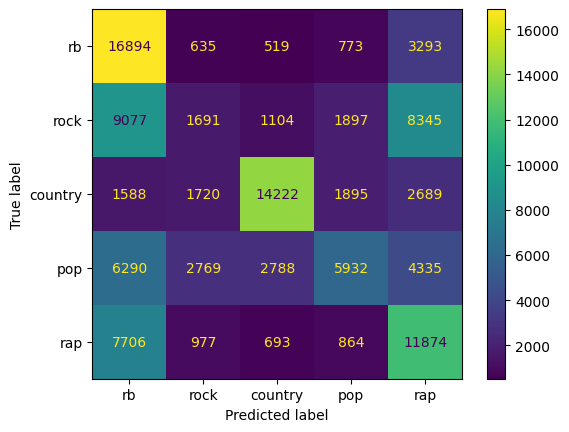

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
tnames = ["rb", "rock", "country", "pop", "rap"]
print(classification_report(dataset_test["tag"], predicted_labels, target_names=tnames))

# Confusion matrix
cm = confusion_matrix(dataset_test["tag"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tnames)
disp.plot()